In [1]:
# Set working directory (optional during development)
import pickle
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())
import contextlib
import io

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics
import scipy.stats as stats
import joblib



# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_prophet import (
    prepare_prophet_data,
    calculate_peak_hours,
    train_baseline_prophet,
    prepare_holiday_df,
    evaluate_metrics,
    select_peak_hours,
    tune_prophet_model,
    evaluate_tuned_model_metrics,
    forecast_with_model_r1,
    forecast_with_model_r2,
    forecast_future_with_model_r1,
    tune_prophet_model_r2,
    select_peak_hours_r2,
    evaluate_metrics_r2,
    forecast_future_with_model_r2
)

from models.model_sarimax import (
    prepare_sarimax_data,
    fit_sarimax_model,
    sarimax_grid_search,
    retrain_sarimax_model,
    create_exogenous_variables,
    fit_sarimax_with_exog,
    evaluate_sarimax_metrics,            # SARIMAX Baseline
    evaluate_refined_sarimax_metrics,    # SARIMAX R1
    evaluate_sarimax_exog_metrics,       # SARIMAX R2 (exog)
    generate_future_forecast_sarimax,    # Future forecast (baseline and R1)
    forecast_future_sarimax_model_refined,  # Future forecast (R1)
    generate_future_forecast_sarimax_exog,  # Future forecast (R2)
    group_forecast_by_hour,              # Peak hour grouping (baseline/R1)
    group_forecast_by_hour_sarimax_exog  # Peak hour grouping (R2)
)


 Working directory: /Users/sudishmakarki/My_project2


In [2]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [3]:
with open("models/prophet_baseline.pkl", "rb") as f:
    loaded_baseline = pickle.load(f)

with open("models/prophet_r1.pkl", "rb") as f:
    loaded_r1 = pickle.load(f)

with open("models/prophet_r2.pkl", "rb") as f:
    loaded_r2 = pickle.load(f)

In [4]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for Prophet
restaurant_train_prophet, restaurant_test_prophet = prepare_prophet_data(restaurant_train, restaurant_test)
# Format for SARIMAX
train_series, test_series = prepare_sarimax_data(restaurant_train, restaurant_test)

In [5]:
# Format the test set (just like before)
restaurant_test_prophet = restaurant_test.reset_index().rename(columns={'Timestamp': 'ds', 'CustomerCount': 'y'})
restaurant_test_prophet['hour'] = restaurant_test_prophet['ds'].dt.hour

# For metric functions that expect CustomerCount
restaurant_test_prophet['CustomerCount'] = restaurant_test_prophet['y']

In [6]:
# Forecasts
fcst_baseline = loaded_baseline.predict(restaurant_test_prophet)
fcst_baseline['Hour'] = fcst_baseline['ds'].dt.hour

fcst_r1 = loaded_r1.predict(restaurant_test_prophet)
fcst_r1['Hour'] = fcst_r1['ds'].dt.hour

fcst_r2 = loaded_r2.predict(restaurant_test_prophet)
fcst_r2['Hour'] = fcst_r2['ds'].dt.hour

In [7]:
# Generate forecast using the loaded R1 model
fcst_r1 = loaded_r1.predict(restaurant_test_prophet)
fcst_r1['Hour'] = fcst_r1['ds'].dt.hour  # needed for peak hour analysisr

In [8]:
# Predict from the baseline model (already loaded from pickle as loaded_baseline)
fcst_baseline = loaded_baseline.predict(restaurant_test_prophet)
fcst_baseline['Hour'] = fcst_baseline['ds'].dt.hour

# Identify peak hours
peak_hours_baseline, _, _ = calculate_peak_hours(fcst_baseline)

# Evaluate baseline metrics
metrics_baseline = evaluate_metrics(
    restaurant_test_prophet,  # actuals with 'y'
    fcst_baseline,
    peak_hours_baseline
)

In [9]:
# 1. Generate fresh forecast from loaded model
fcst_r1 = loaded_r1.predict(restaurant_test_prophet)
fcst_r1['Hour'] = fcst_r1['ds'].dt.hour

# 2. Select peak hours and get peak subsets
peak_hours_r1, _, fcst_peak_r1, test_peak_r1, _ = select_peak_hours(fcst_r1, restaurant_test_prophet)

with contextlib.redirect_stdout(io.StringIO()):
    metrics_r1 = evaluate_tuned_model_metrics(
        restaurant_test,
        fcst_r1,
        test_peak_r1,
        fcst_peak_r1
    )

In [10]:
# Ensure proper column for comparison
actual_customer_counts = restaurant_test_prophet['y']

# Then evaluate metrics
metrics_r2 = evaluate_metrics_r2(
    forecast_df=fcst_r2,                            # must have 'yhat'
    actual_df=pd.DataFrame({
        "ds": restaurant_test_prophet['ds'],
        "CustomerCount": actual_customer_counts     # single actual column
    }),
    customer_col="CustomerCount"
)



In [11]:

# Create comparison table
comparison_data = [
    ["MAE", "Overall", metrics_baseline['mae_all'], metrics_r1['mae_all_best_r1'], metrics_r2['overall']['MAE']],
    ["RMSE", "Overall", metrics_baseline['rmse_all'], metrics_r1['rmse_all_best_r1'], metrics_r2['overall']['RMSE']],
    ["MAPE", "Overall", metrics_baseline['mape_all'], metrics_r1['mape_all_best_r1'], metrics_r2['overall']['MAPE']],
    ["MAE", "Peak Hours", metrics_baseline['mae_peak'], metrics_r1['mae_peak_best_r1'], metrics_r2['peak_hours']['MAE']],
    ["RMSE", "Peak Hours", metrics_baseline['rmse_peak'], metrics_r1['rmse_peak_best_r1'], metrics_r2['peak_hours']['RMSE']],
    ["MAPE", "Peak Hours", metrics_baseline['mape_peak'], metrics_r1['mape_peak_best_r1'], metrics_r2['peak_hours']['MAPE']],
]

# Format into DataFrame
comparison_df = pd.DataFrame(
    comparison_data,
    columns=["Metric", "Type", "Prophet Baseline", "Prophet R1", "Prophet R2"]
)

# Display nicely
comparison_df.style.set_caption("📊 Prophet Model Comparison (Baseline vs R1 vs R2)")\
    .background_gradient(cmap="YlGnBu", subset=["Prophet Baseline", "Prophet R1", "Prophet R2"])


,Metric,Type,Prophet Baseline,Prophet R1,Prophet R2
0,MAE,Overall,6.178833,6.180482,6.094272
1,RMSE,Overall,7.792611,7.787757,7.687272
2,MAPE,Overall,1750259904361487.000000,1799928417792683.250000,1759938633860608.500000
3,MAE,Peak Hours,7.438055,7.429516,7.373625
4,RMSE,Peak Hours,9.273397,9.257146,9.181095
5,MAPE,Peak Hours,0.185381,0.185512,0.184392


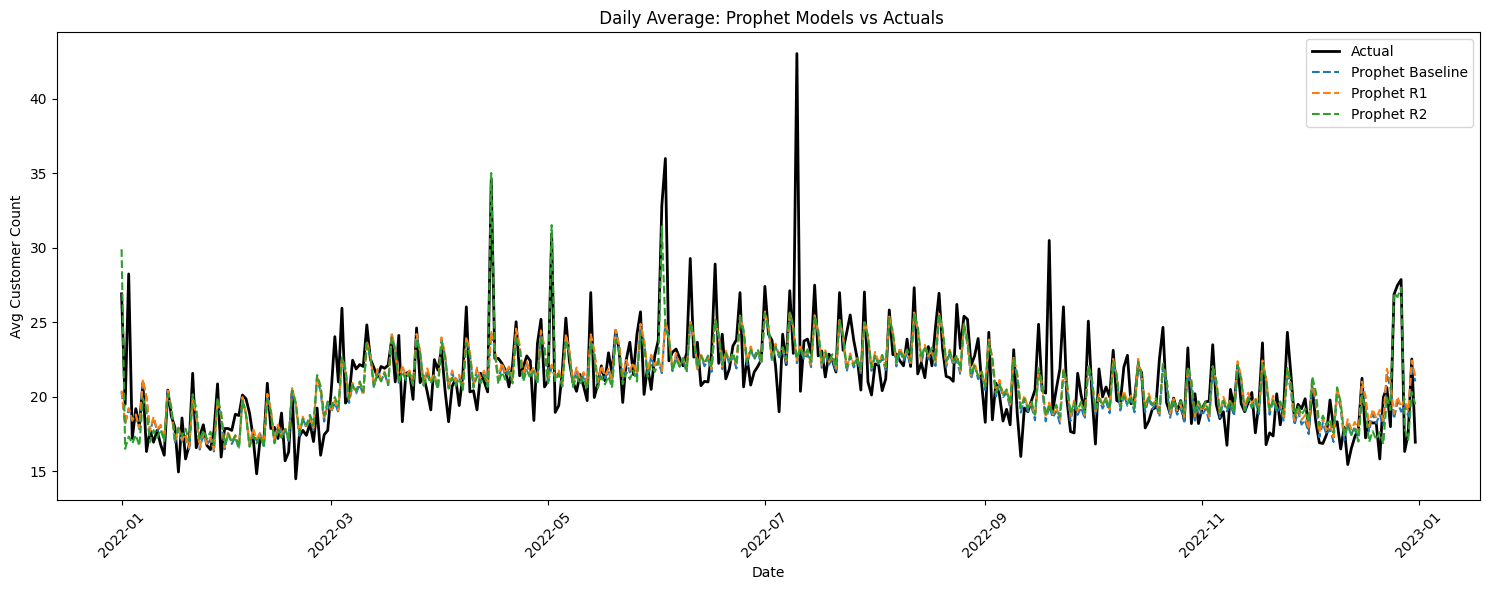

In [17]:
# Daily average to reduce noise
actual_daily = restaurant_test_prophet.groupby(restaurant_test_prophet['ds'].dt.date)['y'].mean().reset_index()
fcst_base_daily = fcst_baseline.groupby(fcst_baseline['ds'].dt.date)['yhat'].mean().reset_index()
fcst_r1_daily = fcst_r1.groupby(fcst_r1['ds'].dt.date)['yhat'].mean().reset_index()
fcst_r2_daily = fcst_r2.groupby(fcst_r2['ds'].dt.date)['yhat'].mean().reset_index()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(actual_daily['ds'], actual_daily['y'], label='Actual', color='black', linewidth=2)
plt.plot(fcst_base_daily['ds'], fcst_base_daily['yhat'], label='Prophet Baseline', linestyle='--')
plt.plot(fcst_r1_daily['ds'], fcst_r1_daily['yhat'], label='Prophet R1', linestyle='--')
plt.plot(fcst_r2_daily['ds'], fcst_r2_daily['yhat'], label='Prophet R2', linestyle='--')

plt.title(" Daily Average: Prophet Models vs Actuals")
plt.xlabel("Date")
plt.ylabel("Avg Customer Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()